In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


# University of Strathclyde - MSc Artificial Intelligence and Applications

# CS982 - Big Data Technologies

File Created first created Xth October 2019 by Barry Smart.

## Stage 8 - Application of Unsupervised Methods
The purpose of this notebook is to run a range of unsupervised models on the data.
The objective is to determine how successfully clustering models can be used to label given the *ground truth* of *Income GrouP*.

 The following high level steps have been applied:
 1. Hierarchical - bottom up - Agglomerative
 2. K Means
 3. Principle Component Analysis - as a useful pre-emtpive stage before applying supervised methods - with a view to reducing the number of variables required.


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn import datasets
from sklearn import metrics
from sklearn import cluster
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage



## Stage 8.1 - Read in the Data and Prepare it for Analysis
 Read in the file that was generated from the warngling and cleaning scripts.

In [2]:
data_path = str(os.getcwd()) + "\\assignment1\\"
interpolated_data_set = pd.read_pickle(data_path + "interpolated_data_set.pkl")

 This step was added retrospectively, because inspection of the data shows that we will be required to work with "Log GDP" in order to generate more meaningful analysis.

In [3]:
interpolated_data_set["Log GDP per Capita"] = np.log10(interpolated_data_set["GDP per capita (current US$)"])


## Stage 8.2 - Prepare Data For Models
 Analysis will be carried out based on the average for each country within a specific decade - the logic being that this will enable fluctuations within that decade to be generalised using the mean.
 Based on the analysis of correlations between variables, reduce the number of variables that will be passed to the model.


In [4]:
# Summarise dataset by calculating mean values for the 1990s decade
analysis_of_decade = interpolated_data_set.xs("1990s", level="Decade", drop_level=False)
analysis_of_decade = analysis_of_decade.groupby(level=["Region", "Income Group", "Country", "Decade"]).\
    mean().reset_index()


In [5]:
# Reduce number of variables and dropping any NA values as they will cause the model to break!
analysis_of_decade_nulls_removed = analysis_of_decade.\
    loc[:, ["Income Group",\
        "Country", \
            "Log GDP per Capita",\
                "Life expectancy at birth, total (years)",\
                    "Renewable energy consumption (% of total final energy consumption)",\
                        'Inflation, consumer prices (annual %)',\
                                'Merchandise exports (current US$)',\
                                    "Immunization, DPT (% of children ages 12-23 months)",\
                                        "Urban population growth (annual %)",\
                                            "Mortality rate, infant (per 1,000 live births)"]]\
        .dropna()

analysis_of_decade_nulls_removed


Series Name,Income Group,Country,Log GDP per Capita,"Life expectancy at birth, total (years)",Renewable energy consumption (% of total final energy consumption),"Inflation, consumer prices (annual %)",Merchandise exports (current US$),"Immunization, DPT (% of children ages 12-23 months)",Urban population growth (annual %),"Mortality rate, infant (per 1,000 live births)"
0,High income,Australia,4.296581,77.935561,8.391483,2.505652,5.029760e+10,87.6,1.054293,6.10
1,High income,Brunei,4.167639,71.346700,0.130969,2.054974,2.366000e+09,96.8,3.242289,9.69
5,High income,Japan,4.533818,79.730512,4.118502,1.210592,3.782012e+11,83.2,0.449741,4.10
6,High income,Korea,3.976264,73.540488,0.797295,5.735745,1.058702e+11,84.7,1.892314,9.57
9,High income,New Zealand,4.170658,76.768293,29.269711,2.112777,1.183120e+10,85.1,1.673539,7.48
...,...,...,...,...,...,...,...,...,...,...
211,Upper middle income,Botswana,3.491550,55.004000,44.762835,10.792873,2.116600e+09,94.9,5.615540,45.10
212,Upper middle income,Equatorial Guinea,2.598237,50.902900,77.592271,6.618479,2.272000e+08,73.7,6.966310,117.00
213,Upper middle income,Gabon,3.672486,60.106000,72.932588,3.696810,2.440500e+09,63.3,4.024594,57.98
214,Upper middle income,Mauritius,3.510909,70.230732,37.318176,7.610752,1.446800e+09,88.7,0.931907,19.03


In [6]:
ground_truth = analysis_of_decade_nulls_removed.iloc[:,0]
ground_truth.value_counts()


High income            51
Upper middle income    42
Lower middle income    37
Low income             20
Name: Income Group, dtype: int64

In [7]:
countries = analysis_of_decade_nulls_removed.iloc[:,1]



In [8]:
dataset_variables = analysis_of_decade_nulls_removed.iloc[:, 2:]
dataset_variables.describe()



Series Name,Log GDP per Capita,"Life expectancy at birth, total (years)",Renewable energy consumption (% of total final energy consumption),"Inflation, consumer prices (annual %)",Merchandise exports (current US$),"Immunization, DPT (% of children ages 12-23 months)",Urban population growth (annual %),"Mortality rate, infant (per 1,000 live births)"
count,150.000000,150.000000,150.000000,150.000000,1.500000e+02,150.000000,150.000000,150.000000
mean,3.326737,66.156304,35.150702,82.527145,2.885705e+10,80.428619,2.402428,41.501000
std,0.669950,9.764242,32.612343,319.876800,7.774828e+10,18.300122,2.021290,35.466911
min,2.208278,33.984200,0.000000,0.790635,8.200000e+06,22.100000,-1.766425,4.100000
25%,2.760610,58.788925,4.240511,3.631911,4.370750e+08,73.475000,0.790813,12.142500
50%,3.266710,68.901385,26.253295,8.198845,2.269250e+09,87.612500,2.388095,28.850000
75%,3.857120,73.262493,65.861059,22.878841,1.426842e+10,93.185714,4.022620,70.727500
max,4.650273,79.730512,98.004536,3367.184985,5.517818e+11,99.000000,9.983684,130.510000


## Stage 8.3 - Establish The Variables (X)

In [9]:
X = scale(dataset_variables)
X


C:\Users\barry\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


array([[ 1.45248763,  1.21040819, -0.82327312, ...,  0.39318894,
        -0.66920186, -1.00148549],
       [ 1.25937691,  0.53335264, -1.07741577, ...,  0.89760201,
         0.41689944, -0.89992528],
       [ 1.80778501,  1.39485308, -0.95473549, ...,  0.15194791,
        -0.96929606, -1.058065  ],
       ...,
       [ 0.51781151, -0.62171473,  1.16239606, ..., -0.93911949,
         0.80522888,  0.46618681],
       [ 0.27582569,  0.41867842,  0.06668443, ...,  0.4534992 ,
        -0.72995329, -0.63569901],
       [ 0.30108267, -0.50655428, -0.53455606, ..., -0.26474115,
         0.30291199,  0.11907156]])

In [10]:
n_samples, n_features = X.shape
print("n_samples: " + str(n_samples) + " - n_features: " + str(n_features))


n_samples: 150 - n_features: 8


## Stage 8.3 - Establish The Ground Truth (Y)

In [11]:
target_number_of_clusters = len(np.unique(ground_truth))
target_number_of_clusters


4

In [12]:
Y = LabelEncoder().fit_transform(ground_truth)
Y


array([0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 1, 2,
       2, 2, 2, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

## Stage 8.4 - Agglomerative Model
 Really useful documentation about this model in the [SciKit Learn web site](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)

 "Recursively merges the pair of clusters that minimally increases a given linkage distance."

 Key parameters are as follows:
 - Affinity - method used to compute the linkage - can be: “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”;
 - Linkage - which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

 Explore the of different distance and affinity measures on the silhouette score, homogeneity and completeness, based on passing different parameters to the Agglomerative clustering algorithm.
 Options available at http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

In [13]:
def run_agglomerative_model(X, Y, target_number_of_clusters):
    affinity_list = ["euclidean", "l1", "l2", "manhattan", "cosine"]
    linkage_list = ["ward", "complete", "average"]
    results_dataframe = pd.DataFrame([])
    for affinity_option in affinity_list:
        for linkage_option in linkage_list:
            if(linkage_option == "ward" and affinity_option != "euclidean"):
                # If linkage is “ward”, only “euclidean” is accepted. 
                continue
            else:
                agglomerative_model = cluster.AgglomerativeClustering(n_clusters=target_number_of_clusters,\
                    linkage=linkage_option, affinity=affinity_option)
                agglomerative_model.fit(X)
                silhouette_score = metrics.silhouette_score(X, agglomerative_model.labels_)
                completeness_score = metrics.completeness_score(Y, agglomerative_model.labels_)
                homogeneity_score = metrics.homogeneity_score(Y, agglomerative_model.labels_)
                #print("Affinity: {}, Linkage: {}, Silhouette: {:0.3f}, Completeness: {:0.3f}, Homogeneity: {:0.3f}".\
                #    format(affinity_option, linkage_option, silhouette_score, completeness_score, homogeneity_score))
                results_dataframe = results_dataframe.append({"Affinity" : affinity_option, "Linkage" : linkage_option,\
                    "Silhouette" : silhouette_score, "Completeness" : completeness_score, "Homogeneity" : homogeneity_score}, ignore_index=True)
    return results_dataframe
    

In [14]:
agglomerative_paramter_analysis = run_agglomerative_model(X, Y, target_number_of_clusters)
agglomerative_paramter_analysis


,Affinity,Completeness,Homogeneity,Linkage,Silhouette
0,euclidean,0.501510,0.309420,ward,0.435368
1,euclidean,0.478634,0.268287,complete,0.469286
2,euclidean,0.251034,0.033384,average,0.389241
3,l1,0.447195,0.294452,complete,0.432461
4,l1,0.532109,0.268474,average,0.446828
5,l2,0.478634,0.268287,complete,0.469286
6,l2,0.251034,0.033384,average,0.389241
7,manhattan,0.447195,0.294452,complete,0.432461
8,manhattan,0.532109,0.268474,average,0.446828
9,cosine,0.456784,0.338985,complete,0.117966


In [15]:
# Save data frame to CSV so that it can be imported into document.
agglomerative_paramter_analysis.to_csv("./assignment1/agglomerative_paramter_analysis.csv")


## Stage 8.5 - K Means
 Useful documentation from Scikit Learn web site:
 [https://scikit-learn.org/stable/modules/clustering.html#k-means] (https://scikit-learn.org/stable/modules/clustering.html#k-means)

 The objective here is to iterative through a range of target clusters for the K-means algorithm to assess how it performs.

In [16]:
def run_k_means_model(X, Y, max_number_of_clusters):
    results_dataframe = pd.DataFrame([])
    for k_means_number_of_clusters in range(2, max_number_of_clusters+1):
        # Configure the model
        kmeans_model = cluster.KMeans(n_clusters=k_means_number_of_clusters)
        # Run the model
        kmeans_model.fit(X)
        # Score the model
        silhouette_score = metrics.silhouette_score(X, kmeans_model.labels_)
        completeness_score = metrics.completeness_score(Y, kmeans_model.labels_)
        homogeneity_score = metrics.homogeneity_score(Y, kmeans_model.labels_)
        # Print the results
        # print("Number of clusters: {}, Silhouette: {:0.3f}, Completeness: {:0.3f}, Homogeneity: {:0.3f}".\
        # format(k_means_number_of_clusters, silhouette_score, completeness_score, homogeneity_score))
        # Capture the results
        results_dataframe = results_dataframe.append({"k_means_number_of_clusters" : k_means_number_of_clusters,\
        "silhouette_score" : silhouette_score, "completeness_score" : completeness_score, "homogeneity_score" : homogeneity_score}, ignore_index=True)
    return results_dataframe


In [17]:
kmeans_parameter_analysis = run_k_means_model(X, Y, 10)
kmeans_parameter_analysis = kmeans_parameter_analysis.set_index("k_means_number_of_clusters")
kmeans_parameter_analysis


,completeness_score,homogeneity_score,silhouette_score
k_means_number_of_clusters,,,
2.0,0.558602,0.259738,0.467290
3.0,0.484364,0.295449,0.439871
4.0,0.457371,0.291661,0.444852
5.0,0.458044,0.435209,0.310659
6.0,0.431807,0.482290,0.291044
7.0,0.431008,0.523677,0.279790
8.0,0.365858,0.488024,0.248574
9.0,0.346539,0.516453,0.256116
10.0,0.353698,0.543110,0.261044


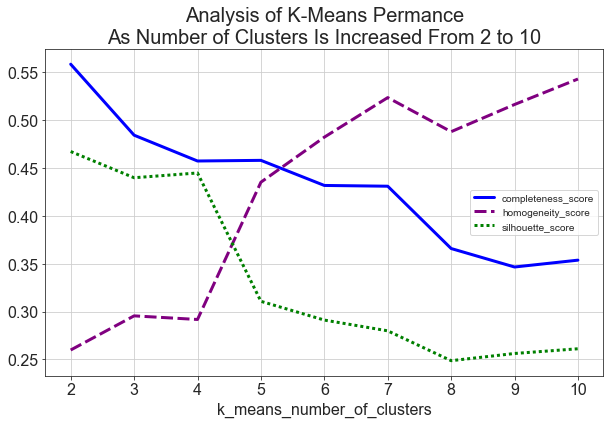

In [18]:
score_palette = {"completeness_score": "blue", "silhouette_score": "green", "homogeneity_score": "purple"}
sns.set_style("ticks", {'axes.grid': True, 'grid.color': '.8', 'grid.linestyle': '-', })
plt.rcParams.update({'axes.titlesize' : 18, 'lines.linewidth' : 3,\
    'axes.labelsize' : 16, 'xtick.labelsize' : 16, 'ytick.labelsize' : 16})
f, ax = plt.subplots(figsize=(10, 6))
plt.title("Analysis of K-Means Permance\nAs Number of Clusters Is Increased From 2 to 10", fontdict = {"fontsize" : 20})
sns.lineplot(linewidth=3,\
    palette=score_palette,\
    data=kmeans_parameter_analysis, ax=ax)


In [19]:
# Save results to file so that it can be imported into document.
kmeans_parameter_analysis.to_csv("./assignment1/kmeans_parameter_analysis.csv")


## Stage 8.6 Run Agglomerative Clustering With Optimal Parameters
 The best combination being:
 - Affinity = Euclidean
 - Linkage = Ward


In [20]:
model = cluster.AgglomerativeClustering(n_clusters=target_number_of_clusters, linkage='ward', affinity='euclidean')


In [21]:
model.fit(X)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4,
                        pooling_func='deprecated')

In [22]:
# Let's look at the labels that the model has assigned
model.labels_


array([0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0], dtype=int64)

In [23]:
# The number of labels should tally with the number of observations passed into the model.
len(model.labels_)


150

 Now evaluate the performance of the culstering algorithm

## Silhouette Score
 The Silhouette Coefficient is calculated using:
 - the mean intra-cluster distance (a), and;
 -  the mean nearest-cluster distance (b) for each sample.

The Silhouette Coefficient for a sample is (b - a) / max(a, b).

 Advantages:
 - The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
 - The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

In [24]:
metrics.silhouette_score(X, model.labels_)


0.4353681954962387

## Completeness Score
 Completeness metric of a cluster labeling given a *ground truth*.
 A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

In [25]:
metrics.completeness_score(Y, model.labels_)


0.5015101720894144

## Homogeneity Score
Homogeneity metric of a cluster labeling given a ground truth.
A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

In [26]:
metrics.homogeneity_score(Y, model.labels_)


0.30942049595268034

## Stage 8.7 Visualise Results Of Agglomerative Clustering
 Visualise how the aggromerative model has performed when compared to the "ground truth" labels.


In [27]:
# Splice the labels assigned by the Agglomerative cluster back onto the original data set:
analysis_of_decade_nulls_removed["Agglomerative Clustering Labels"] = model.labels_


In [28]:
# To enable evaluation of model, assign integer labels to each row so that they align in general with the labels assigned by the clustering algorith.
def label_income_group (row):
    if row["Income Group"] == "High income":
        return 2
    if row["Income Group"] == "Upper middle income":
        return 0
    if row["Income Group"] == "Lower middle income":
        return 3
    if row["Income Group"] == "Low income":
        return 1
    return 4

analysis_of_decade_nulls_removed["Ground Truth Encoded"] = \
    analysis_of_decade_nulls_removed.apply (lambda row: label_income_group(row), axis=1)


In [29]:
# Now compute the difference between "known truth" (Income Group) and labels assigned by model
analysis_of_decade_nulls_removed['Difference Between Ground Truth and Clustering'] = analysis_of_decade_nulls_removed["Ground Truth Encoded"]\
     - analysis_of_decade_nulls_removed["Agglomerative Clustering Labels"]


In [30]:
# Set up palette for plot to enable like with like comparison
income_group_palette = {"High income": "red", "Upper middle income": "orange", "Lower middle income": "green", "Low income": "blue"}
cluster_palette = { 2: "red", 0: "orange", 3: "green", 1: "blue"}
diff_palette = {4: "darkred", 3: "red", 2: "orangered", 1: "orange", 0: "black",\
    -4: "darkgreen", -3: "seagreen", -2: "green", -1: "lightgreen"}



In [31]:
# Helper function to enable data to be plotted consistently
def plot_clusters(dataframe, title, x_column, y_column, size_column, hue_column, hue_palette):
    sns.set_style("ticks", {'axes.grid': True, 'grid.color': '.8', 'grid.linestyle': '--', 
        'axes.titlesize' : 18, 'lines.linewidth' : 1, 'axes.labelsize' : 18, 'xtick.labelsize' : 16,\
        'ytick.labelsize' : 16})
    f, ax = plt.subplots(figsize=(10, 6))
    chart = sns.scatterplot(x = x_column, y = y_column,\
        hue = hue_column,\
        palette = hue_palette,\
        size = size_column, \
        sizes = (50,200),\
        alpha = 0.8,\
        linewidth = 0,\
        data=dataframe, ax = ax)
    chart.axes.set_title(title,fontsize=18)


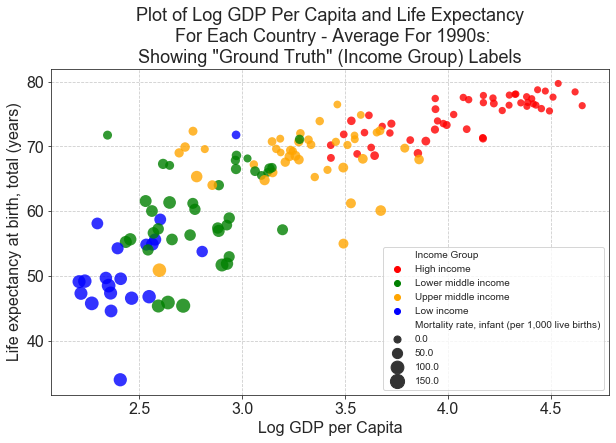

In [32]:
plot_clusters(analysis_of_decade_nulls_removed, "Plot of Log GDP Per Capita and Life Expectancy\n For Each Country - Average For 1990s:\nShowing \"Ground Truth\" (Income Group) Labels", "Log GDP per Capita",\
    "Life expectancy at birth, total (years)", "Mortality rate, infant (per 1,000 live births)", "Income Group", income_group_palette)


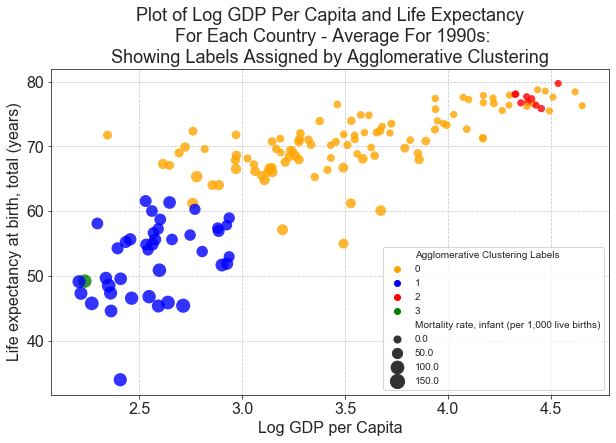

In [33]:
plot_clusters(analysis_of_decade_nulls_removed, "Plot of Log GDP Per Capita and Life Expectancy\n For Each Country - Average For 1990s:\nShowing Labels Assigned by Agglomerative Clustering",\
     "Log GDP per Capita", "Life expectancy at birth, total (years)", "Mortality rate, infant (per 1,000 live births)",\
          "Agglomerative Clustering Labels", cluster_palette)


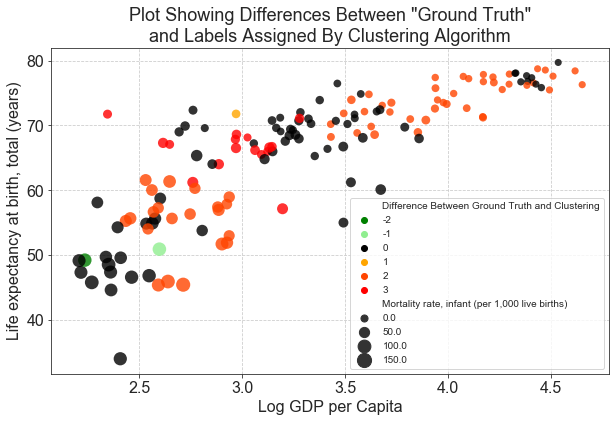

In [34]:
plot_clusters(analysis_of_decade_nulls_removed, "Plot Showing Differences Between \"Ground Truth\"\nand Labels Assigned By Clustering Algorithm",\
    "Log GDP per Capita", "Life expectancy at birth, total (years)", "Mortality rate, infant (per 1,000 live births)",\
        "Difference Between Ground Truth and Clustering", diff_palette)


## Stage 8.8 Generate a Dendrogram
 Visualise how the aggromerative model has been contructed from the ground up.


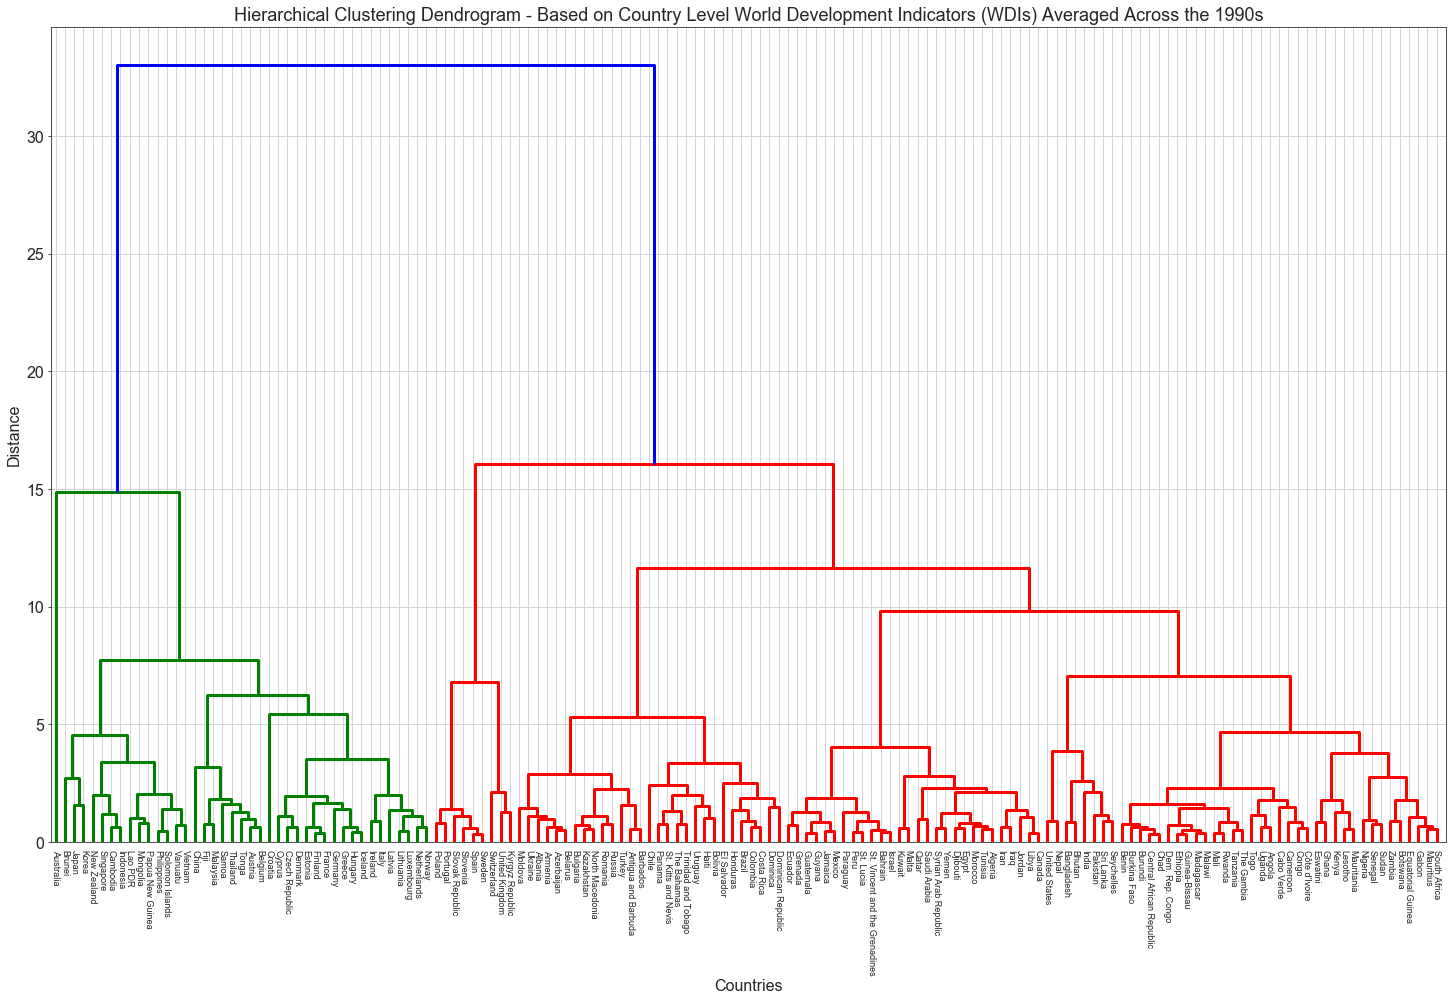

In [35]:
linkage_model = linkage(X, 'ward')
sns.set_style("ticks", {'axes.grid': True, 'grid.color': '.8', 'grid.linestyle': '-'})
f, ax = plt.subplots(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram - Based on Country Level World Development Indicators (WDIs) Averaged Across the 1990s')
plt.xlabel('Countries')
plt.ylabel('Distance')
dendrogram(linkage_model, leaf_rotation=270, leaf_font_size=9.,)
locs, labels = plt.xticks()
step = 10
end = 5 + ((len(countries) + 1) * step)
plt.xticks(np.arange(5, end, step), countries.to_numpy())

plt.show()


In [36]:
labels[1]


Text(15, 0, 'Brunei')

In [37]:
linkage_model


array([[ 80.        ,  87.        ,   0.35078658,   2.        ],
       [ 35.        ,  48.        ,   0.35104526,   2.        ],
       [ 41.        ,  43.        ,   0.35384617,   2.        ],
       [  6.        ,   8.        ,   0.37874849,   2.        ],
       [ 56.        ,  59.        ,   0.38667533,   2.        ],
       [ 31.        ,  92.        ,   0.38885759,   2.        ],
       [ 67.        ,  91.        ,   0.38973451,   2.        ],
       [ 25.        ,  32.        ,   0.3938962 ,   2.        ],
       [123.        , 129.        ,   0.4121651 ,   2.        ],
       [ 24.        ,  93.        ,   0.42053036,   2.        ],
       [  1.        ,  89.        ,   0.42431687,   2.        ],
       [128.        , 139.        ,   0.45437223,   2.        ],
       [ 62.        , 114.        ,   0.4578199 ,   2.        ],
       [116.        , 121.        ,   0.46492276,   2.        ],
       [ 78.        ,  79.        ,   0.49845104,   2.        ],
       [152.        , 157

In [38]:
countries.to_numpy()


array(['Australia', 'Brunei', 'Japan', 'Korea', 'New Zealand',
       'Singapore', 'Cambodia', 'Indonesia', 'Lao PDR', 'Mongolia',
       'Papua New Guinea', 'Philippines', 'Solomon Islands', 'Vanuatu',
       'Vietnam', 'China', 'Fiji', 'Malaysia', 'Samoa', 'Thailand',
       'Tonga', 'Austria', 'Belgium', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'United Kingdom', 'Kyrgyz Republic',
       'Moldova', 'Ukraine', 'Albania', 'Armenia', 'Azerbaijan',
       'Belarus', 'Bulgaria', 'Kazakhstan', 'North Macedonia', 'Romania',
       'Russia', 'Turkey', 'Antigua and Barbuda', 'Barbados', 'Chile',
       'Panama', 'St. Kitts and Nevis', 'The Bahamas',
       'Trinidad and Tobago', 'Uruguay', 'Haiti', 'Bolivia',

In [39]:
X


array([[ 1.45248763,  1.21040819, -0.82327312, ...,  0.39318894,
        -0.66920186, -1.00148549],
       [ 1.25937691,  0.53335264, -1.07741577, ...,  0.89760201,
         0.41689944, -0.89992528],
       [ 1.80778501,  1.39485308, -0.95473549, ...,  0.15194791,
        -0.96929606, -1.058065  ],
       ...,
       [ 0.51781151, -0.62171473,  1.16239606, ..., -0.93911949,
         0.80522888,  0.46618681],
       [ 0.27582569,  0.41867842,  0.06668443, ...,  0.4534992 ,
        -0.72995329, -0.63569901],
       [ 0.30108267, -0.50655428, -0.53455606, ..., -0.26474115,
         0.30291199,  0.11907156]])

## Stage 8.9 - Principle Components Analysis
 Principle component analysis (PCA) is fundamentally a dimensionality reduction algorthim.
 Useful for visualisation, noise filtering, feature extraction and engineering.
 According to Vanderplas 2017 it is a fast and flexible method for dimensionality reduction in data.

 My plan here is to apply a PCA to my data by asking it to fit to a decreasing number of components.
 I will be passing D variables, and intially ask it to fit to D-1 components.
 Then I will step this down to 1 and plot the results.

 Documentation:
 (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)[https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html]

 This is also interesting:
 (http://setosa.io/ev/eigenvectors-and-eigenvalues/)[http://setosa.io/ev/eigenvectors-and-eigenvalues/]

In [40]:
from sklearn.decomposition import PCA


In [41]:
pca = PCA()


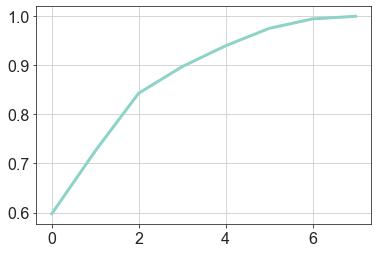

In [42]:
pca = pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [43]:
pca.explained_variance_ratio_


array([0.59724017, 0.12797673, 0.11786445, 0.05418364, 0.0425185 ,
       0.03547958, 0.01929287, 0.00544407])

In [44]:
pca.explained_variance_


array([4.80998792, 1.03068504, 0.94924392, 0.43637828, 0.34243091,
       0.28574159, 0.15537879, 0.04384483])

In [45]:
pca.components_




array([[-0.39950432, -0.43401176,  0.3952309 ,  0.09344904, -0.19044464,
        -0.37033128,  0.34691949,  0.43968438],
       [-0.03345414,  0.03368026, -0.116223  ,  0.94612964, -0.02913031,
        -0.13027479, -0.26688324, -0.00553346],
       [ 0.20870395, -0.02636449,  0.09411412,  0.05857776,  0.90993244,
        -0.27884253,  0.17211778,  0.09002235],
       [ 0.22262297,  0.11882441, -0.01081978,  0.2828888 , -0.10247667,
         0.34812068,  0.83891208, -0.14392244],
       [-0.51804081, -0.21819271,  0.05862037,  0.07908001,  0.3374138 ,
         0.73531737, -0.10547246,  0.093121  ],
       [-0.26680083, -0.11993355, -0.89653438, -0.07658543,  0.04898807,
        -0.16016512,  0.20623   ,  0.1849609 ],
       [-0.63397086,  0.59961473,  0.1162625 , -0.0228637 ,  0.08571044,
        -0.24778941,  0.14268337, -0.36796602],
       [-0.06848926, -0.61168224, -0.02414567,  0.00261362,  0.02845295,
        -0.1385567 ,  0.03175518, -0.77430504]])